In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Data preprocessing

In [2]:
table=pd.read_csv("fer2013.csv").values
x=list()
for i in range(table.shape[0]):
    table[i][1]=np.uint8(np.asarray(table[i][1].split(' ')).reshape((48,48,1)))
    x.append(table[i][1])
    print("Current row : %d"%i,end="\r")
print("\nDone!")
table=table[:,:-1]
x=np.float32(np.asarray(x))/255.0
y=np.uint8(table[:,0])
np.save("xval.npy",x)
np.save("yval.npy",y)
np.save("data.npy",table)

Current row : 35886
Done!


In [7]:
x=np.load('xval.npy')
y=np.load('yval.npy')

In [8]:
table=np.load('data.npy', allow_pickle=True)

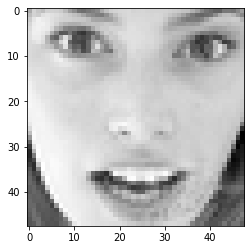

In [9]:
image=x[random.randint(0,x.shape[1]-1)]
plt.imshow(np.asarray(image.reshape(48,48)),cmap='gray')
plt.show()